In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
from xgboost import XGBRegressor
sns.set(style="whitegrid")

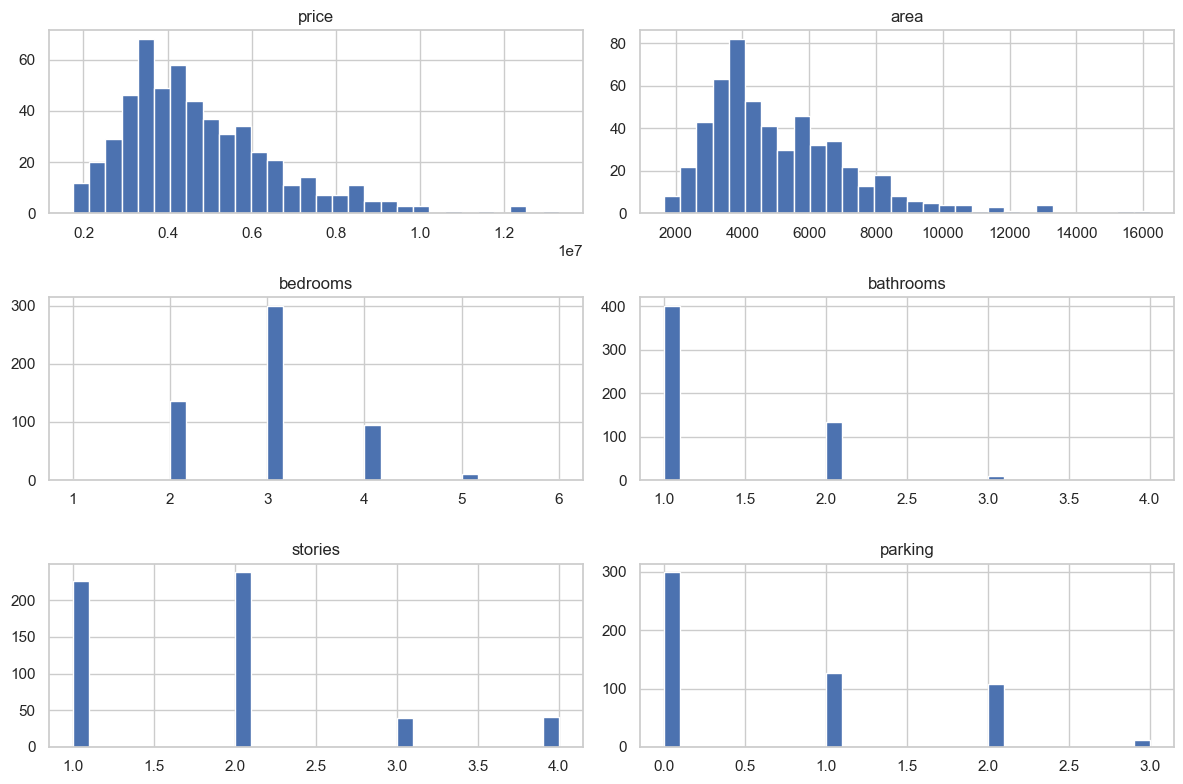

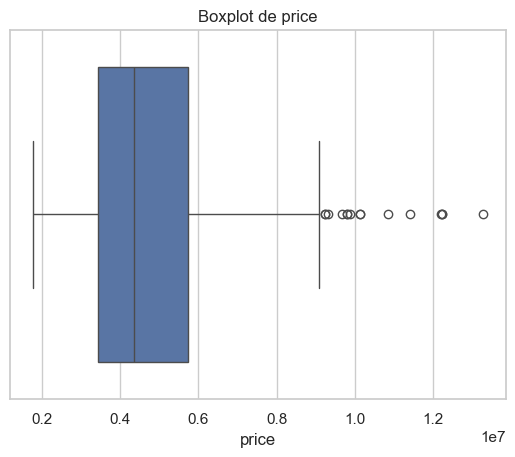

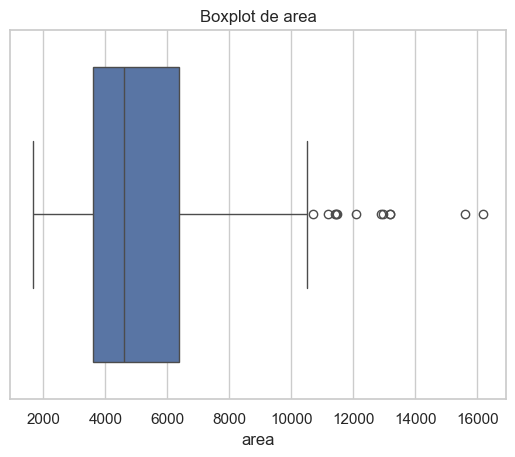

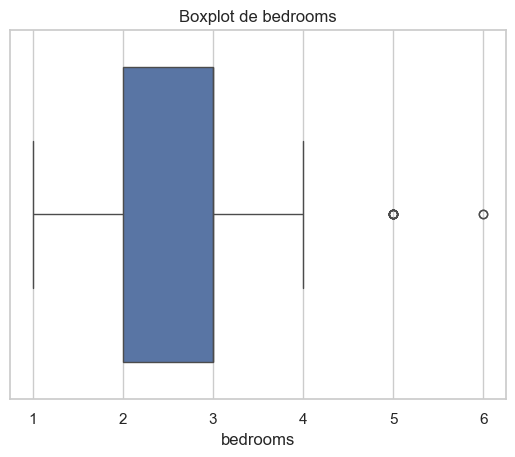

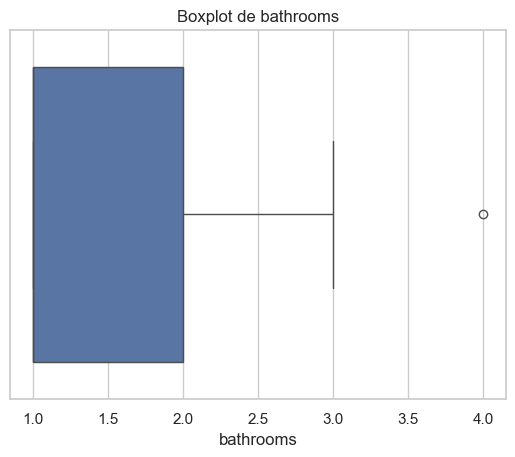

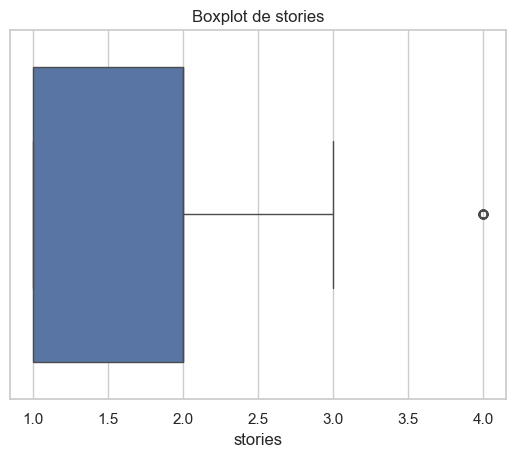

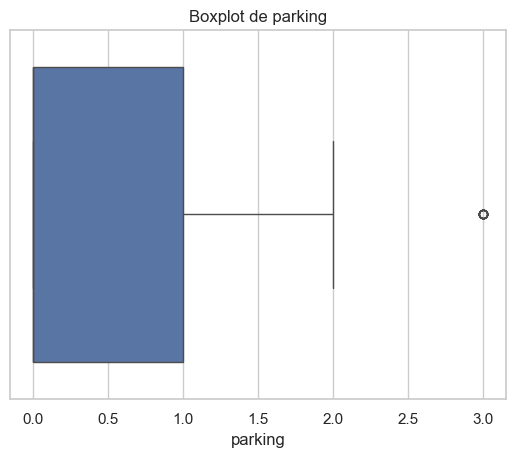

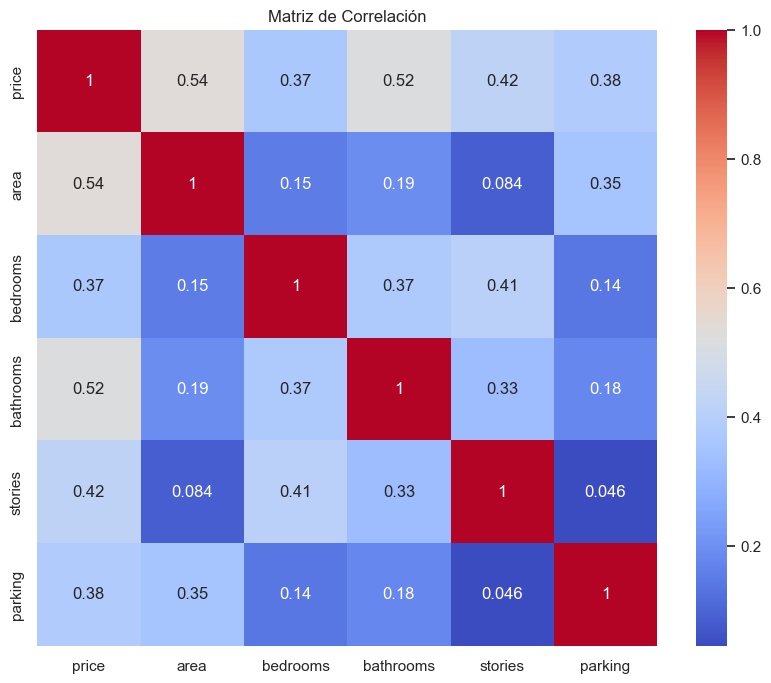

In [3]:


# Cargar dataset
df = pd.read_csv("../../data/raw/Housing.csv")

# Preprocesamiento
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                  'airconditioning', 'prefarea']
df[binary_columns] = df[binary_columns].apply(lambda col: col.map({'yes': 1, 'no': 0}))
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)
df['log_price'] = np.log(df['price'])
df['log_area'] = np.log(df['area'])

# Features y target
features = ['log_area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom',
            'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea',
            'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']
X = df[features]
y = df['log_price']

# EDA: histogramas, boxplots, correlaciones
df[["price", "area", "bedrooms", "bathrooms", "stories", "parking"]].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

for col in ["price", "area", "bedrooms", "bathrooms", "stories", "parking"]:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df[["price", "area", "bedrooms", "bathrooms", "stories", "parking"]].corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()


R2: 0.678234133449721
RMSE: 0.24925762462767723
MAE: 0.19978911295152774
XGBoost CV R2: 0.5712339147358702 +/- 0.05216163431987893


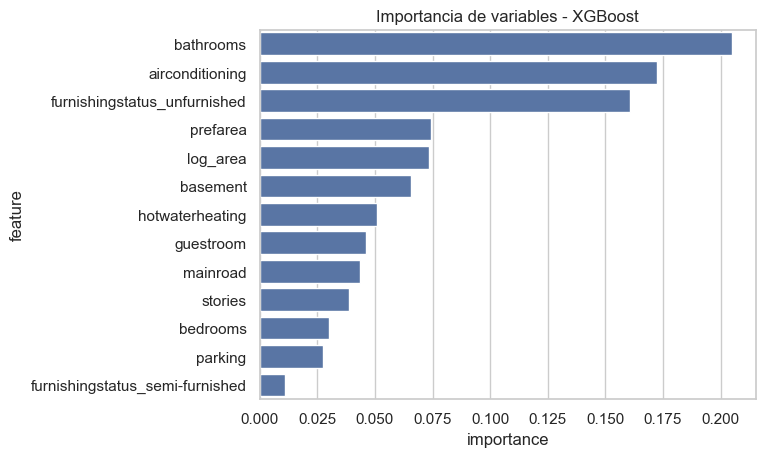

In [4]:

# Regresión lineal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("R2:", r2_score(y_test, y_pred_lr))
# Calcular RMSE tomando la raíz cuadrada del MSE
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))

# XGBoost + CV
xgb = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb, X, y, scoring='r2', cv=cv)
print("XGBoost CV R2:", scores.mean(), "+/-", scores.std())

# Entrenamiento final
xgb.fit(X_train, y_train)

# Importancia de variables
importances = pd.DataFrame({
    'feature': features,
    'importance': xgb.feature_importances_
}).sort_values(by='importance', ascending=False)

sns.barplot(x='importance', y='feature', data=importances)
plt.title("Importancia de variables - XGBoost")
plt.show()

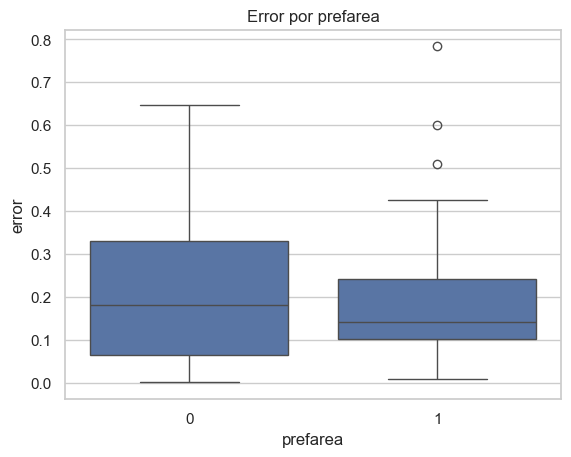

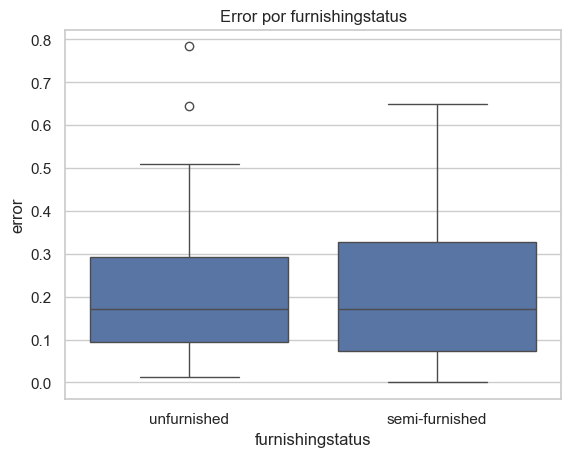

In [5]:


# Error por segmento
y_pred = xgb.predict(X_test)
errors = np.abs(y_test - y_pred)

X_test_copy = X_test.copy()
X_test_copy['error'] = errors
X_test_copy['prefarea'] = df.loc[X_test.index, 'prefarea']
X_test_copy['furnishingstatus'] = df.loc[X_test.index, ['furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']].idxmax(axis=1)
X_test_copy['furnishingstatus'] = X_test_copy['furnishingstatus'].map({
    'furnishingstatus_semi-furnished': 'semi-furnished',
    'furnishingstatus_unfurnished': 'unfurnished'
}).fillna('furnished')


sns.boxplot(x='prefarea', y='error', data=X_test_copy)
plt.title("Error por prefarea")
plt.show()

sns.boxplot(x='furnishingstatus', y='error', data=X_test_copy)
plt.title("Error por furnishingstatus")
plt.show()

